In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.3 MB/s eta 0:00:00


In [3]:
# Tiny dataset
# !gdown https://drive.google.com/uc?id=1qYPCnXXxjEcHEg3tLGt3fDkd2ialAgS4
import os
# Full dataset with jpeg
!gdown https://drive.google.com/uc?id=1-xJoBvzwQKgJjPzHb3fq1sFicwyIisx7

# Full dataset without jpeg
# https://drive.google.com/file/d/1gFSdm8K9SXNPXG9tQWS4bmO_nappN2AL/view?usp=share_link
# !gdown https://drive.google.com/uc?id=1gFSdm8K9SXNPXG9tQWS4bmO_nappN2AL
!unzip data_v1.zip -d /content/data

Downloading...
From: https://drive.google.com/uc?id=1-xJoBvzwQKgJjPzHb3fq1sFicwyIisx7
To: /content/data_v1.zip
100% 640M/640M [00:08<00:00, 76.2MB/s]
Archive:  data_v1.zip
   creating: /content/data/train-images/
  inflating: /content/data/train-images/00000000002.jpg  
  inflating: /content/data/train-images/00000000003.jpg  
  inflating: /content/data/train-images/00000000004.jpg  
  inflating: /content/data/train-images/00000000005.jpg  
  inflating: /content/data/train-images/00000000006.jpg  
  inflating: /content/data/train-images/00000000009.jpg  
  inflating: /content/data/train-images/00000000010.jpg  
  inflating: /content/data/train-images/00000000017.jpg  
  inflating: /content/data/train-images/00000000020.jpg  
  inflating: /content/data/train-images/00000000022.jpg  
  inflating: /content/data/train-images/00000000023.jpg  
  inflating: /content/data/train-images/00000000025.jpg  
  inflating: /content/data/train-images/00000000026.jpg  
  inflating: /content/data/train-

In [4]:
%cd /content/data
import json
data = json.load(open("train_data.json", "r", encoding = 'utf-8'))

/content/data


In [5]:
data['annotations'][0]

{'id': 0,
 'image_id': 2,
 'caption': 'ba chiếc thuyền đang di chuyển ở trên con sông',
 'segment_caption': 'ba chiếc thuyền đang di_chuyển ở trên con sông'}

# Vocab

In [6]:
import json
vocab = json.load(open("/content/drive/MyDrive/IC/ViT/vocab.json", encoding = 'utf-8'))
itos = list(vocab['stoi'])

In [7]:
def batch_decode(predictions_ids):
    preds = []
    for seq in predictions_ids:
        preds.append(" ".join([itos[id] for id in seq if id not in [0,1,2,3]]))
    return preds

# Dataset

In [8]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import json
import os

class IMCP_Test_Dataset(Dataset):
  def __init__(self, image_path = "public-test-images", summary_path = "test_data.json"):
    super().__init__()
    self.data = json.load(open(summary_path, "r", encoding = 'utf-8'))
    self.image_path = image_path
    self.imgid2imgname = {entry['id']: entry['filename'] for entry in self.data['images']}

  def __len__(self):
    return len(self.data['images'])

  def __getitem__(self, index):
    entry = self.data['images'][index]
    image_id = entry['id']
    image_name = entry['filename']
    image = Image.open(os.path.join(self.image_path, image_name)).convert('RGB')
    caption = [self.data['annotations'][i]['segment_caption'] for i in range(len(self.data['annotations'])) if self.data['annotations'][i]['image_id'] == image_id]
    return image, caption, image_id

In [9]:
test_dataset = IMCP_Test_Dataset()

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

# Collator

In [11]:
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
max_seq_len = 256
class IMCP_Collator:
  def __init__(self, vocab, train = True):
    self.vocab = vocab['stoi']
    self.bos_id = self.vocab['<bos>']
    self.eos_id = self.vocab['<eos>']
    self.pad_id = self.vocab['<pad>']
    self.train = train

  def tokenize_texts(self, captions):
    raw_captions = [caption.split(" ") for caption in captions]
    truncated_captions = [s[:max_seq_len] for s in raw_captions]
    max_len = max([len(c) for c in truncated_captions])

    padded_captions = []
    for c in truncated_captions:
        c = [self.vocab[word] for word in c]
        seq = [self.bos_id] + c + [self.eos_id] + [self.pad_id] * (max_len - len(c))
        padded_captions.append(seq)

    padded_captions = [torch.Tensor(seq).long() for seq in padded_captions]
    padded_captions = pad_sequence(padded_captions, batch_first=True)
    return padded_captions
  
  def resize_and_stack(self, images):
    image_tensors = []
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    
    for image in images:
      img_tensor = transform(image)
      image.close()
      image_tensors.append(img_tensor)
      
    stacked = torch.stack(image_tensors)
    return stacked

  def __call__(self, batch):
    if self.train:
      images = [example[0] for example in batch]
      captions = [example[1] for example in batch]
      return self.resize_and_stack(images), self.tokenize_texts(captions)
    else:
      images = [example[0] for example in batch]
      captions = [example[1] for example in batch]
      image_ids = [example[2] for example in batch]
      return self.resize_and_stack(images), captions, image_ids
    

In [12]:
collatorTest = IMCP_Collator(vocab, train = False)

# DataLoader

In [13]:
test_dataloader = DataLoader(test_dataset, batch_size = 16, collate_fn = collatorTest)

# Model

In [14]:
config = {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "MBartModel"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 2,
  "decoder_start_token_id": 1,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 2,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "gradient_checkpointing": False,
  "init_std": 0.02,
  "is_encoder_decoder": True,
  "max_position_embeddings": 256,
  "model_type": "mbart",
  "num_hidden_layers": 2,
  "pad_token_id": 2,
  "scale_embedding": False,
  "torch_dtype": "float32",
  "transformers_version": "4.10.2",
  "use_cache": True,
  "vocab_size": len(vocab['stoi']) + 5
}

In [15]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn.utils.rnn import pack_padded_sequence

from transformers import ViTModel
from transformers import BartForConditionalGeneration, BartConfig

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Vision Transformer encoder
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.linear = nn.Linear(self.vit.config.hidden_size, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, images):
        with torch.no_grad():
            features = self.vit(images)
        features = self.linear(features.last_hidden_state)
        features = self.relu(features)
        features = self.dropout(features)
        return features

# Define Transformer decoder
class Decoder(nn.Module):
    def __init__(self, max_seq_length):
        super(Decoder, self).__init__()
        self.config = BartConfig(**config)
        self.decoder = BartForConditionalGeneration(self.config)
        self.max_seq_length = max_seq_length
    
    def forward(self, features, captions):
        outputs = self.decoder(
            encoder_outputs = [features], ## Use [] instead of () Important!
            labels = captions)
        return outputs

    def generate(self, features, max_length = 50):
        model_kwargs = {
            "encoder_outputs": [features], ## Use [] instead of () Important!
        }
        input_ids = torch.ones((len(features), 1), device=device, dtype=torch.long)
        input_ids = input_ids * 1
        output = self.decoder.generate(input_ids, num_beams=1, max_new_tokens = max_length, **model_kwargs)
        return output


# Define hyperparameters
vocab_size = len(vocab['stoi']) + 5
embed_size = 512
max_seq_length = 30
learning_rate = 0.0001
num_epochs = 2

# Initialize encoder and decoder
encoder = Encoder(embed_size).to(device)
decoder = Decoder(max_seq_length).to(device)


Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Inference

In [16]:
encoder.load_state_dict(torch.load('/content/drive/MyDrive/IC/ViT/encoder.pth'))
decoder.load_state_dict(torch.load('/content/drive/MyDrive/IC/ViT/decoder.pth'))

<All keys matched successfully>

In [17]:
my_preds = []
targets = []
data = []
for i, (images, captions, image_ids) in enumerate(test_dataloader):
    # Move data to GPU
    images = images.to(device)
    # Forward pass
    features = encoder(images)
    out = decoder.generate(features)
    preds = out.detach().cpu().numpy()
    preds = batch_decode(preds)
    my_preds.extend(preds)
    for pred, image_id in zip(preds, image_ids):
        data.append({
            "image_id": image_id,
            "caption": pred
        })
    targets.extend(captions)

In [18]:
import json
with open("result_vittrans.json", "w", encoding="utf-8") as file:
    json.dump(data, file, ensure_ascii = False)

In [19]:
import matplotlib.pyplot as plt

def image_captioning(image_name: str):
    image = Image.open(image_name).convert('RGB')
    plt.imshow(image)
    images = collatorTest.resize_and_stack([image])
    images = images.to(device)
    features = encoder(images)
    out = decoder.generate(features)
    preds = out.detach().cpu().numpy()
    plt.title(batch_decode(preds)[0])
    plt.show()

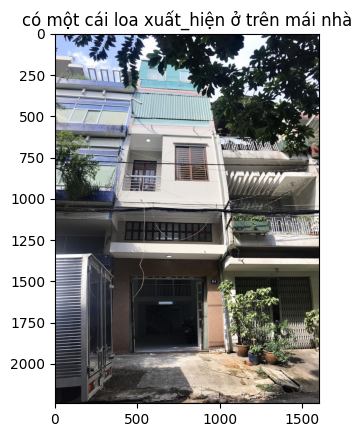

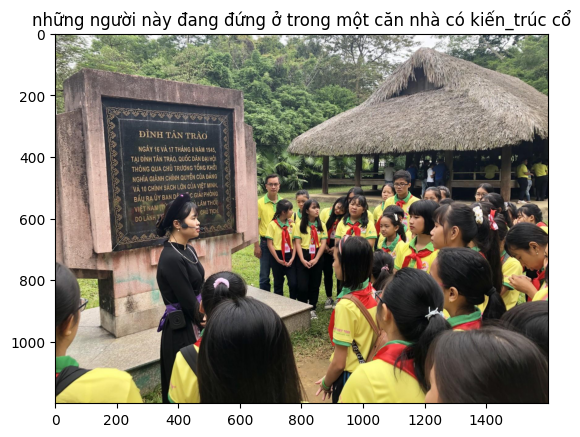

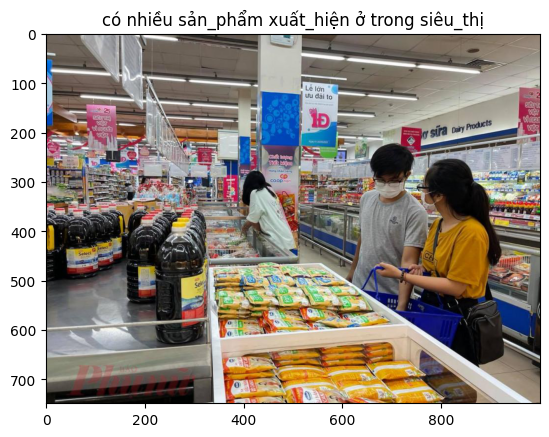

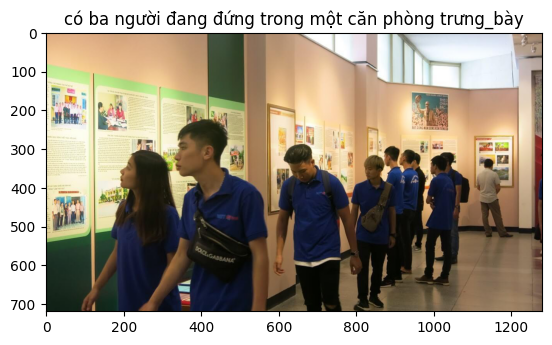

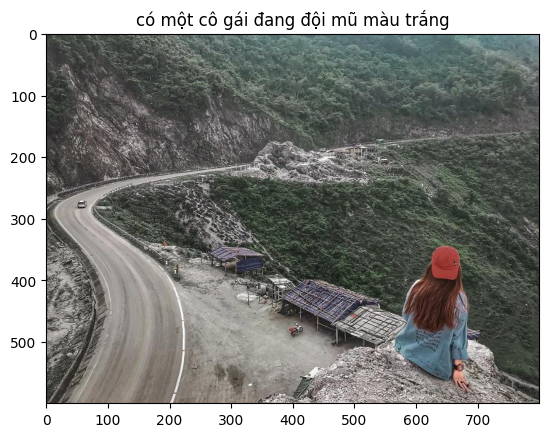

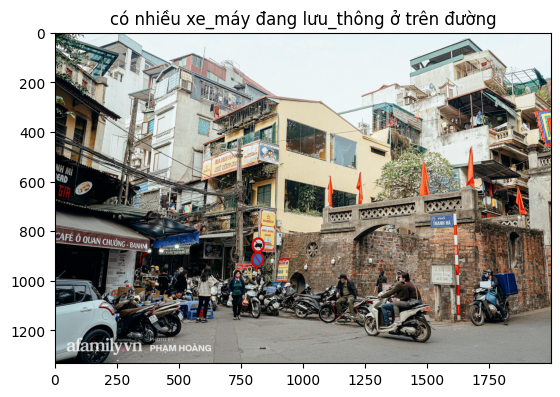

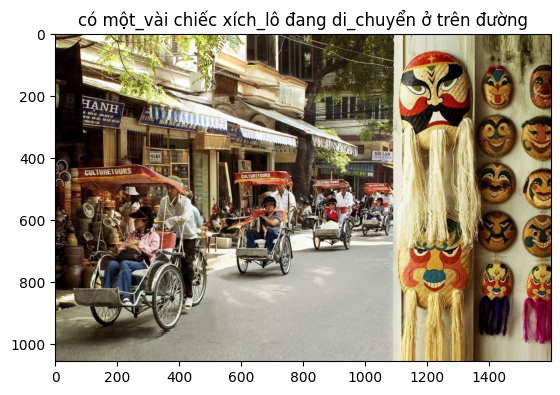

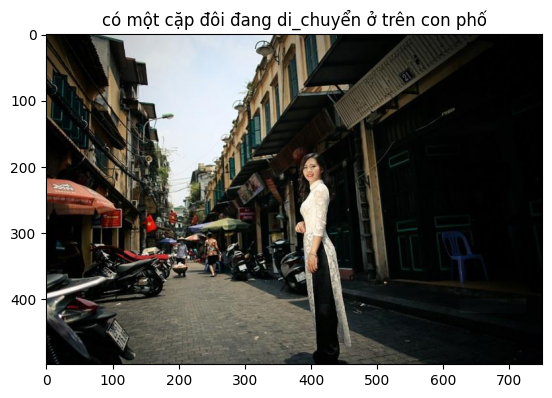

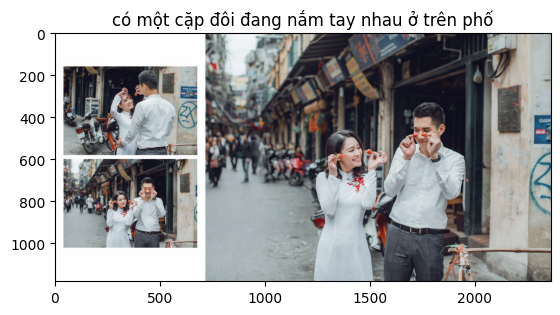

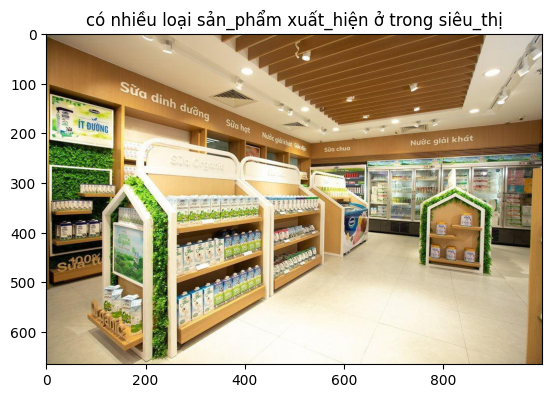

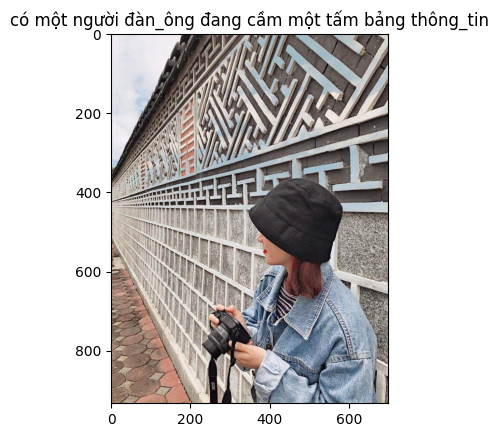

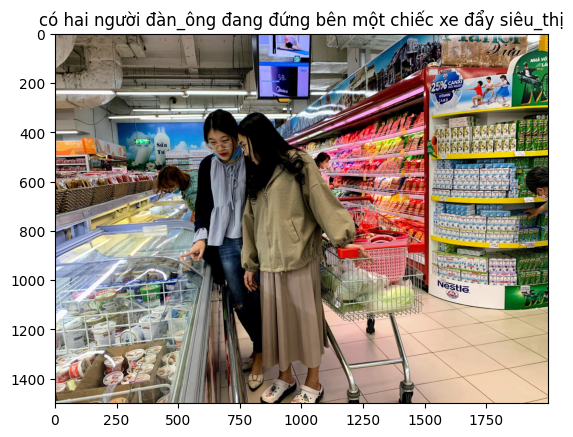

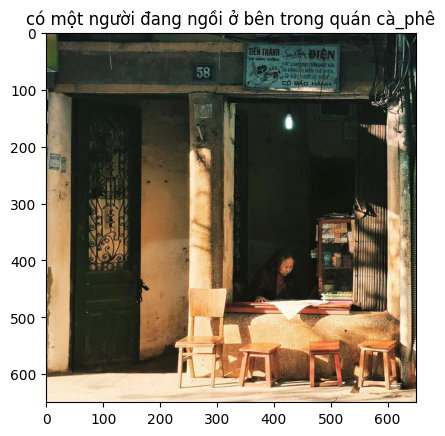

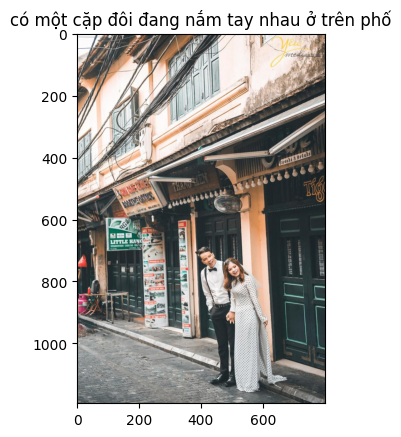

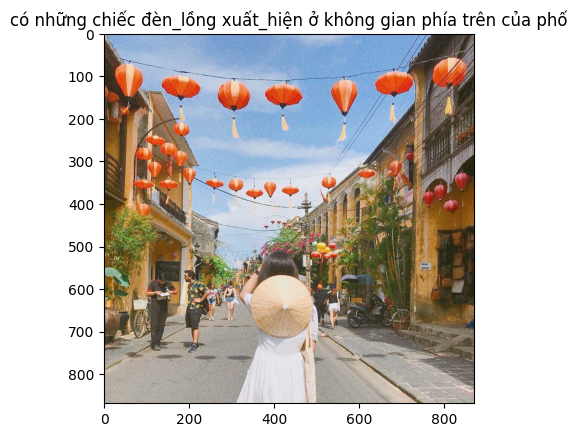

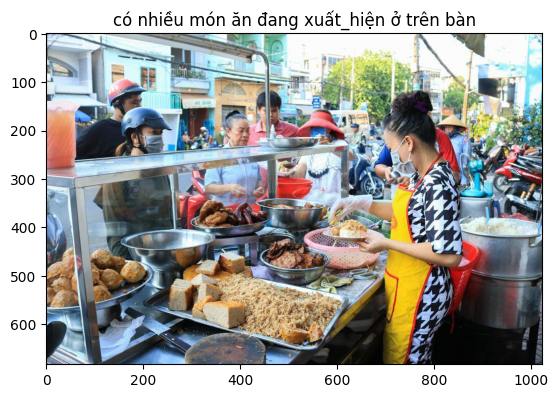

In [20]:
image_captioning("public-test-images/00000000001.jpg")
image_captioning("public-test-images/00000000078.jpg")
image_captioning("public-test-images/00000000115.jpg")
image_captioning("public-test-images/00000000118.jpg")
image_captioning("public-test-images/00000000190.jpg")
image_captioning("public-test-images/00000000322.jpg")
image_captioning("public-test-images/00000000331.jpg")
image_captioning("public-test-images/00000000363.jpg")
image_captioning("public-test-images/00000000490.jpg")
image_captioning("public-test-images/00000000657.jpg")
image_captioning("public-test-images/00000000702.jpg")
image_captioning("public-test-images/00000000834.jpg")
image_captioning("public-test-images/00000001052.jpg")
image_captioning("public-test-images/00000001109.jpg")
image_captioning("public-test-images/00000009770.jpg")
image_captioning("public-test-images/00000011015.jpeg")